In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv
/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl


In [2]:
!python --version


Python 3.11.11


In [3]:
# CELLULE 1: Imports et v√©rification des fichiers
# ====================================================================================

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ====================================================================================
# CELLULE 2: Installation des packages n√©cessaires
# ====================================================================================

!pip install rouge-score
!pip install pytorch-lightning

# ====================================================================================
# CELLULE 3: Imports des biblioth√®ques
# ====================================================================================

import pandas as pd 
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

print("‚úÖ Toutes les biblioth√®ques import√©es avec succ√®s!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

# ====================================================================================
# CELLULE 4: Fonctions de pr√©processing am√©lior√©es
# ====================================================================================

def clean_arabic_text(text):
    """Nettoyage plus doux du texte arabe - pr√©servation de la structure"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Supprimer les URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Supprimer les caract√®res de contr√¥le
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Normaliser les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Normalisation des lettres arabes communes (optionnel)
    text = text.replace('ÿ£', 'ÿß').replace('ÿ•', 'ÿß').replace('ÿ¢', 'ÿß')
    text = text.replace('ÿ©', 'Ÿá')
    
    # Supprimer les diacritiques (ÿ™ÿ¥ŸÉŸäŸÑ) - optionnel
    arabic_diacritics = re.compile(r'[\u064B-\u0652\u0670\u0640]')
    text = arabic_diacritics.sub('', text)
    
    return text.strip()

def analyze_text_stats(df):
    """Analyser les statistiques du texte"""
    print("üìä Statistiques des textes:")
    print(f"Nombre total d'exemples: {len(df)}")
    
    df['paragraph_len'] = df['paragraph'].str.len()
    df['summary_len'] = df['summary'].str.len()
    
    print(f"Longueur moyenne des paragraphes: {df['paragraph_len'].mean():.2f}")
    print(f"Longueur moyenne des r√©sum√©s: {df['summary_len'].mean():.2f}")
    print(f"Longueur max des paragraphes: {df['paragraph_len'].max()}")
    print(f"Longueur max des r√©sum√©s: {df['summary_len'].max()}")
    
    return df

# ====================================================================================
# CELLULE 5: Chargement et pr√©paration des donn√©es
# ====================================================================================

def prepare_data():
    """Charger et pr√©parer les donn√©es d'entra√Ænement"""
    print("üîÑ Chargement des donn√©es...")
    
    # Charger les donn√©es
    data = pd.read_csv('/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv')
    data = data.drop(['id', 'url', 'title'], axis=1)
    data = data.rename(columns={'text': 'paragraph', 'summary': 'summary'})
    
    print(f"Donn√©es brutes: {len(data)} exemples")
    
    # Supprimer les doublons
    data = data.drop_duplicates(subset=['paragraph'])
    data = data.drop_duplicates(subset=['summary'])
    print(f"Apr√®s suppression des doublons: {len(data)} exemples")
    
    # Nettoyer le texte
    print("üßπ Nettoyage des textes...")
    data['paragraph'] = data['paragraph'].apply(clean_arabic_text)
    data['summary'] = data['summary'].apply(clean_arabic_text)
    
    # Filtrer les donn√©es vides ou anormales
    data = data[
        (data['paragraph'].str.len() > 50) & 
        (data['summary'].str.len() > 10) &
        (data['paragraph'].str.len() < 2000) &  # √âviter les textes trop longs
        (data['summary'].str.len() < 500)
    ]
    
    print(f"Donn√©es finales apr√®s filtrage: {len(data)} exemples")
    
    # Analyser les statistiques
    data = analyze_text_stats(data)
    
    return data.reset_index(drop=True)

# Charger les donn√©es
xl_sum = prepare_data()
xl_sum.head()

/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv
/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=47acf025d95ddfc9f143475f0875ac0e055ecc53ae1c553d7d3817ff48e76d26
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

2025-06-22 10:48:24.764883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750589305.188087      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750589305.299928      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


‚úÖ Toutes les biblioth√®ques import√©es avec succ√®s!
PyTorch version: 2.6.0+cu124
CUDA disponible: True
üîÑ Chargement des donn√©es...
Donn√©es brutes: 46897 exemples
Apr√®s suppression des doublons: 46690 exemples
üßπ Nettoyage des textes...
Donn√©es finales apr√®s filtrage: 25253 exemples
üìä Statistiques des textes:
Nombre total d'exemples: 25253
Longueur moyenne des paragraphes: 1272.40
Longueur moyenne des r√©sum√©s: 141.84
Longueur max des paragraphes: 1999
Longueur max des r√©sum√©s: 489


summary  \
0  ŸÇÿßŸÑÿ™ ÿßŸÑÿ¥ÿ±ÿ∑Ÿá ŸÅŸä ÿßŸÑŸÇÿ∑ÿßÿπ ÿßŸÑŸáŸÜÿØŸä ŸÖŸÜ ÿßŸÇŸÑŸäŸÖ ŸÉÿ¥ŸÖŸäÿ± ÿßŸÜ...   
1  ÿßŸÉÿØ ŸÖÿµÿØÿ± ŸÅŸä "ÿßŸÑÿ≠ÿ±ÿßŸÉ ÿßŸÑÿ™ŸáÿßŸÖŸä" ŸÑÿßÿ®ŸÜÿßÿ° ŸÖÿ≠ÿßŸÅÿ∏Ÿá ÿßŸÑÿ≠...   
2  ÿßŸÅÿßÿØÿ™ ŸÖÿµÿßÿØÿ± ÿ≠ÿ±ŸÉŸá ÿ≠ŸÖÿßÿ≥ ÿßŸÜ ŸÉÿ™ÿßÿ¶ÿ® ÿßŸÑŸÇÿ≥ÿßŸÖÿå ÿßŸÑÿ¨ŸÜÿßÿ≠ ...   
3  ÿßŸÅÿßÿØÿ™ ŸÖÿµÿßÿØÿ± ŸÖŸÇÿ±ÿ®Ÿá ŸÖŸÜ ÿßŸÑŸÖÿπÿßÿ±ÿ∂Ÿá ÿßŸÑÿ≥Ÿàÿ±ŸäŸá ÿ®ŸÖŸÇÿ™ŸÑ ÿßŸÉ...   
4  ÿßÿ≥ÿ™ŸÇÿßŸÑ ÿ±ÿ¶Ÿäÿ≥ ÿßŸÑÿßÿ±ŸÉÿßŸÜ ÿßŸÑŸÑŸäÿ®Ÿä ŸäŸàÿ≥ŸÅ ÿßŸÑŸÖŸÜŸÇŸàÿ¥ ÿßÿ´ÿ± ŸÖŸÇ...   

                                           paragraph  paragraph_len  \
0  Ÿàÿ∞ŸÉÿ±ÿ™ ŸàŸÉÿßŸÑŸá ÿßŸÑÿßŸÜÿ®ÿßÿ° ÿßŸÑŸÖÿ≠ŸÑŸäŸá (ÿ¨Ÿä.ÿßŸÜ.ÿßÿ≥) ÿßŸÜ ÿ¨ŸÖÿßÿπ...            646   
1  ŸÖÿ≥ŸÑÿ≠ ÿ≠Ÿàÿ´Ÿä ŸÅŸä ÿßÿ® ŸàŸÇÿßŸÑ ÿßŸÑŸÖÿµÿØÿ± ÿßŸÜ ÿßŸÑŸÖÿ≥ŸÑÿ≠ŸäŸÜ ÿßŸÑÿ≠Ÿàÿ´Ÿä...           1100   
2  ŸàŸÉÿßŸÜÿ™ ÿßÿ∞ÿßÿπŸá ÿßŸÑÿ¨Ÿäÿ¥ ÿßŸÑÿßÿ≥ÿ±ÿßÿ¶ŸäŸÑŸä ÿßŸÅÿßÿØÿ™ ÿ®ŸÖŸÇÿ™ŸÑ ÿ´ŸÑÿßÿ´Ÿá...            342   
3  ŸÖÿ≥ŸÑÿ≠Ÿà ÿßŸÑŸÖÿπÿßÿ±ÿ∂Ÿá ŸÅŸä ÿ±ŸäŸÅ ÿ≠ŸÑÿ® ŸàŸÇÿßŸÑ Ÿäÿßÿ≥ŸäŸÜ ÿßÿ®Ÿà ÿ±ÿßÿ¶ÿØ ...            425   
4  ŸÇÿ®ŸÑ ÿßŸÑŸÖÿ§ÿ™ŸÖÿ± ÿßŸÑÿπÿßŸÖ ÿßŸÑŸàÿ∑ŸÜŸä ÿßŸÑŸÑŸäÿ®Ÿä ÿßŸÑÿßÿ≥ÿ™ŸÇÿßŸÑŸá ŸàŸÇÿ®ŸÑ...            600   

   summary_len  
0          163  
1          324  
2          109  
3          163  
4          145

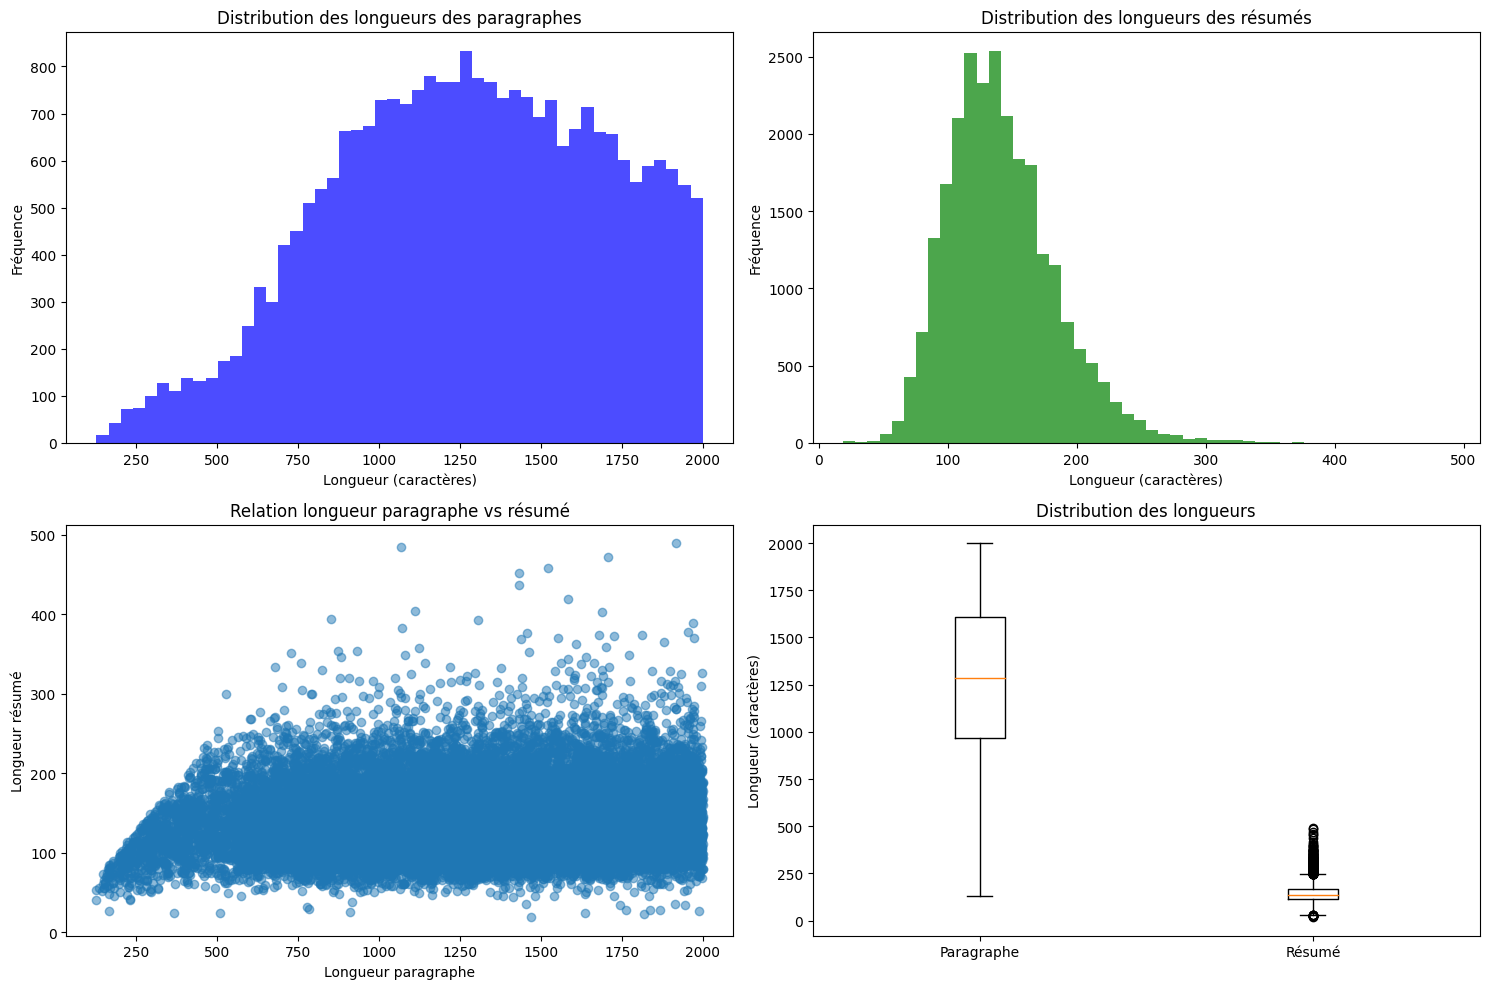


üìÑ Exemples de donn√©es:

--- Exemple 1 ---
Paragraphe: Ÿàÿ∞ŸÉÿ±ÿ™ ŸàŸÉÿßŸÑŸá ÿßŸÑÿßŸÜÿ®ÿßÿ° ÿßŸÑŸÖÿ≠ŸÑŸäŸá (ÿ¨Ÿä.ÿßŸÜ.ÿßÿ≥) ÿßŸÜ ÿ¨ŸÖÿßÿπŸá "ÿ¨Ÿäÿ¥ ŸÖÿ≠ŸÖÿØ" ÿßŸÑŸÖÿ™ÿ¥ÿØÿØŸá ÿßÿπŸÑŸÜÿ™ ŸÖÿ≥ÿ§ŸàŸÑŸäÿ™Ÿáÿß ÿπŸÜ ÿßŸÑŸáÿ¨ŸàŸÖ. ŸÑŸÉŸÜ ŸÖÿß ŸáŸä ŸÖŸÜÿ∑ŸÇŸá ŸÉÿ¥ŸÖŸäÿ± ÿßŸÑŸÖÿ™ŸÜÿßÿ≤ÿπ ÿπŸÑŸäŸáÿß ÿ®ŸäŸÜ ÿßŸÑŸáŸÜÿØ Ÿàÿ®ÿßŸÉÿ≥ÿ™ÿßŸÜÿü ÿÆŸÑÿßŸÑ ÿßŸÑÿπŸÇŸàÿØ ÿßŸÑÿ≥ÿ™ ÿßŸÑŸÖÿßÿ∂ŸäŸá ÿ∏ŸÑÿ™ ŸÖŸÜÿ∑ŸÇŸá ŸÉÿ¥ŸÖŸäÿ± ÿßŸÑŸÇÿ±Ÿäÿ®Ÿá...
R√©sum√©: ŸÇÿßŸÑÿ™ ÿßŸÑÿ¥ÿ±ÿ∑Ÿá ŸÅŸä ÿßŸÑŸÇÿ∑ÿßÿπ ÿßŸÑŸáŸÜÿØŸä ŸÖŸÜ ÿßŸÇŸÑŸäŸÖ ŸÉÿ¥ŸÖŸäÿ± ÿßŸÜ ÿßŸÜŸÅÿ¨ÿßÿ± ŸÇŸÜÿ®ŸÑŸá ÿßÿØŸâ ÿßŸÑŸâ ŸÖŸÇÿ™ŸÑ 40 ÿπŸÜÿµÿ±ÿß ÿπŸÑŸâ ÿßŸÑÿßŸÇŸÑ ŸÖŸÜ ŸÇŸàÿßÿ™ ÿßŸÑÿßŸÖŸÜ ÿßŸÑÿÆŸÖŸäÿ≥ÿå ÿ®ÿπÿØ ŸäŸàŸÖ ŸÖŸÜ ÿßŸÜŸÅÿ¨ÿßÿ± ÿßÿØŸâ ŸÑÿßÿµÿßÿ®Ÿá 12 ÿ™ŸÑŸÖŸäÿ∞ÿß ÿπŸÑŸâ ÿßŸÑÿßŸÇŸÑ.

--- Exemple 2 ---
Paragraphe: ŸÖÿ≥ŸÑÿ≠ ÿ≠Ÿàÿ´Ÿä ŸÅŸä ÿßÿ® ŸàŸÇÿßŸÑ ÿßŸÑŸÖÿµÿØÿ± ÿßŸÜ ÿßŸÑŸÖÿ≥ŸÑÿ≠ŸäŸÜ ÿßŸÑÿ≠Ÿàÿ´ŸäŸäŸÜ Ÿáÿßÿ¨ŸÖŸàÿß ŸÜÿ¥ÿ∑ÿßÿ° ÿßŸÑÿ≠ÿ±ÿßŸÉ ÿßŸÑÿ™ŸáÿßŸÖŸä ŸÑÿßŸÅÿ¥ÿßŸÑ ÿ™ÿ±ÿ™Ÿäÿ®ÿßÿ™ ŸÉÿßŸÜŸàÿß Ÿäÿ¨ÿ±ŸàŸÜŸáÿß ŸÑÿ™ŸÜÿ∏ŸäŸÖ ÿ≠ÿ¥ŸàÿØ ÿßŸÑÿ¨ŸÖÿπŸá ÿ™ÿ≠ÿ™ ÿ¥ÿπÿß

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


‚úÖ Tokenizer charg√©. Vocab size: 250100
üìä Split des donn√©es:
   Train: 21465 exemples
   Validation: 3788 exemples
‚úÖ DataLoaders cr√©√©s avec batch_size=8
   Train batches: 2684
   Val batches: 474

üîç Test d'un batch:
   input_ids shape: torch.Size([8, 512])
   attention_mask shape: torch.Size([8, 512])
   labels shape: torch.Size([8, 128])


In [4]:
# ====================================================================================
# CELLULE 6: Visualisation des donn√©es
# ====================================================================================

# Cr√©er des visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des longueurs des paragraphes
axes[0,0].hist(xl_sum['paragraph_len'], bins=50, alpha=0.7, color='blue')
axes[0,0].set_title('Distribution des longueurs des paragraphes')
axes[0,0].set_xlabel('Longueur (caract√®res)')
axes[0,0].set_ylabel('Fr√©quence')

# Distribution des longueurs des r√©sum√©s
axes[0,1].hist(xl_sum['summary_len'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Distribution des longueurs des r√©sum√©s')
axes[0,1].set_xlabel('Longueur (caract√®res)')
axes[0,1].set_ylabel('Fr√©quence')

# Scatter plot
axes[1,0].scatter(xl_sum['paragraph_len'], xl_sum['summary_len'], alpha=0.5)
axes[1,0].set_title('Relation longueur paragraphe vs r√©sum√©')
axes[1,0].set_xlabel('Longueur paragraphe')
axes[1,0].set_ylabel('Longueur r√©sum√©')

# Box plot
data_lengths = [xl_sum['paragraph_len'], xl_sum['summary_len']]
axes[1,1].boxplot(data_lengths, labels=['Paragraphe', 'R√©sum√©'])
axes[1,1].set_title('Distribution des longueurs')
axes[1,1].set_ylabel('Longueur (caract√®res)')

plt.tight_layout()
plt.show()

# Afficher quelques exemples
print("\nüìÑ Exemples de donn√©es:")
for i in range(3):
    print(f"\n--- Exemple {i+1} ---")
    print(f"Paragraphe: {xl_sum['paragraph'].iloc[i][:200]}...")
    print(f"R√©sum√©: {xl_sum['summary'].iloc[i]}")

# ====================================================================================
# CELLULE 7: Classe Dataset
# ====================================================================================

class ArabicSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_len=512, target_max_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True)  # ‚úÖ Important !
        self.source_max_len = source_max_len
        self.target_max_len = target_max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        paragraph = str(self.data.iloc[index]['paragraph'])
        summary = str(self.data.iloc[index]['summary'])

        # Encodage source
        source = self.tokenizer(
            paragraph,
            max_length=self.source_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Encodage target  
        target = self.tokenizer(
            summary,
            max_length=self.target_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # ‚úÖ CORRECTION: Remplacer les tokens de padding par -100 (ignor√©s dans la loss)
        labels = target['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

print("‚úÖ Classe Dataset d√©finie!")

# ====================================================================================
# CELLULE 8: Mod√®le Lightning
# ====================================================================================

class MT5Summarizer(pl.LightningModule):
    def __init__(self, model_name="google/mt5-small", lr=3e-5, warmup_steps=1000):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = MT5Tokenizer.from_pretrained(model_name)
        self.lr = lr
        self.warmup_steps = warmup_steps
        # ‚úÖ CORRECTION: use_stemmer=False pour l'arabe
        self.rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
        
        # Sauvegarder les hyperparam√®tres
        self.save_hyperparameters()
        
        # M√©triques pour le suivi
        self.validation_step_outputs = []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss

        # G√©n√©ration pour √©valuation ROUGE
        with torch.no_grad():
            preds = self.model.generate(
                batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                max_length=128,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )
        
        pred_str = self.tokenizer.batch_decode(preds, skip_special_tokens=True)
        
        # ‚úÖ CORRECTION: D√©coder les labels correctement
        labels = batch['labels'].clone()
        labels[labels == -100] = self.tokenizer.pad_token_id
        label_str = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Calculer ROUGE
        rouge1_total, rouge2_total, rougel_total = 0, 0, 0
        valid_samples = 0
        
        for pred, label in zip(pred_str, label_str):
            if pred.strip() and label.strip():  # √âviter les cha√Ænes vides
                # ‚úÖ CORRECTION: Ordre correct pred, label
                scores = self.rouge.score(pred, label)
                rouge1_total += scores["rouge1"].fmeasure
                rouge2_total += scores["rouge2"].fmeasure
                rougel_total += scores["rougeL"].fmeasure
                valid_samples += 1

        if valid_samples > 0:
            self.log('val_loss', loss, prog_bar=True)
            self.log('rouge1', rouge1_total / valid_samples, prog_bar=True)
            self.log('rouge2', rouge2_total / valid_samples, prog_bar=True)
            self.log('rougeL', rougel_total / valid_samples, prog_bar=True)
            
            # Stocker pour affichage
            self.validation_step_outputs.append({
                'val_loss': loss,
                'rouge1': rouge1_total / valid_samples,
                'rouge2': rouge2_total / valid_samples,
                'rougeL': rougel_total / valid_samples
            })

        return loss
    
    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            avg_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
            avg_rouge1 = np.mean([x['rouge1'] for x in self.validation_step_outputs])
            avg_rouge2 = np.mean([x['rouge2'] for x in self.validation_step_outputs])
            avg_rougeL = np.mean([x['rougeL'] for x in self.validation_step_outputs])
            
            print(f"\nüìä √âpoque {self.current_epoch}:")
            print(f"   Val Loss: {avg_loss:.4f}")
            print(f"   ROUGE-1: {avg_rouge1:.4f}")
            print(f"   ROUGE-2: {avg_rouge2:.4f}")
            print(f"   ROUGE-L: {avg_rougeL:.4f}")
            
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        
        # Learning rate scheduler avec warmup
        def lr_lambda(current_step):
            if current_step < self.warmup_steps:
                return float(current_step) / float(max(1, self.warmup_steps))
            return max(0.0, float(self.trainer.max_steps - current_step) / float(max(1, self.trainer.max_steps - self.warmup_steps)))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

print("‚úÖ Mod√®le MT5Summarizer d√©fini!")

# ====================================================================================
# CELLULE 9: Pr√©paration des DataLoaders
# ====================================================================================

# Charger le tokenizer
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
print(f"‚úÖ Tokenizer charg√©. Vocab size: {tokenizer.vocab_size}")

# Split train/validation
train_df, val_df = train_test_split(xl_sum, test_size=0.15, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"üìä Split des donn√©es:")
print(f"   Train: {len(train_df)} exemples")
print(f"   Validation: {len(val_df)} exemples")

# Cr√©er les datasets
train_dataset = ArabicSummaryDataset(train_df, tokenizer)
val_dataset = ArabicSummaryDataset(val_df, tokenizer)

# DataLoaders avec batch size optimis√©
batch_size = 8 if torch.cuda.is_available() else 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

print(f"‚úÖ DataLoaders cr√©√©s avec batch_size={batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Tester un batch
sample_batch = next(iter(train_loader))
print(f"\nüîç Test d'un batch:")
print(f"   input_ids shape: {sample_batch['input_ids'].shape}")
print(f"   attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"   labels shape: {sample_batch['labels'].shape}")

# ====================================================================================
# CELLULE 10: Configuration de l'entra√Ænement
# ====================================================================================

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='rouge1',
    dirpath='./checkpoints',
    filename='mt5-best-{epoch:02d}-{rouge1:.4f}',
    save_top_k=2,
    mode='max',  # ‚úÖ Maximiser ROUGE-1
    save_weights_only=False,
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor='rouge1',
    patience=5,
    verbose=True,
    mode='max'
)


In [5]:
# Trainer avec configuration optimis√©e
trainer = pl.Trainer(
    max_epochs=10,  # ‚úÖ Plus d'√©poques
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,  # ‚úÖ Gradient accumulation
    precision=16,  # ‚úÖ Mixed precision pour √©conomiser la m√©moire
    log_every_n_steps=50,
    val_check_interval=0.5,  # Valider 2 fois par √©poque
    enable_progress_bar=True
)

print("‚úÖ Trainer configur√©!")
print(f"   Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"   Max epochs: {trainer.max_epochs}")
print(f"   Gradient accumulation: {trainer.accumulate_grad_batches}")

‚úÖ Trainer configur√©!
   Device: GPU
   Max epochs: 10
   Gradient accumulation: 2


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


In [6]:
import pandas as pd 
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
import joblib
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import F1Score
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm


In [7]:
data = []
xl_sum = pd.DataFrame(data, columns=['text', 'summary'])
second = pd.read_csv('/kaggle/input/arabic-summarization-bbc-news/bbc_news_arabic_summarization.csv')
second = second.drop(['id','url','title'],axis=1)


xl_sum = pd.concat([xl_sum,second])
new_column_names = {
    'text': 'paragraph',
    'summary': 'summary',
}

# Rename the columns using the dictionary
xl_sum = xl_sum.rename(columns=new_column_names)
xl_sum.head(5)

paragraph  \
0  ŸàŸÉÿßŸÜ ÿßŸÑÿ±ÿ¶Ÿäÿ≥ ÿßŸÑÿ£ŸàŸÉÿ±ÿßŸÜŸä ÿßŸÑŸÖÿ§ŸÇÿ™ÿå ÿßŸÑŸÉÿ≥ŸÜÿØÿ± ÿ™Ÿàÿ±ÿ™ÿ¥ŸäŸÜŸà...   
1  ÿ®ÿ≠ŸÑŸàŸÑ ÿπÿßŸÖ 2050 ÿ≥ÿ™ÿ≠ÿ™ÿßÿ¨ ŸÖÿµÿ± ÿ•ŸÑŸâ 21 ŸÖŸÑŸäÿßÿ± ŸÖÿ™ÿ± ŸÖŸÉÿπ...   
2  Ÿàÿ∞ŸÉÿ±ÿ™ ŸàŸÉÿßŸÑÿ© ÿßŸÑÿ£ŸÜÿ®ÿßÿ° ÿßŸÑŸÖÿ≠ŸÑŸäÿ© (ÿ¨Ÿä.ÿ•ŸÜ.ÿ•ÿ≥) ÿ£ŸÜ ÿ¨ŸÖÿßÿπ...   
3  ŸàŸàŸÇÿπ ÿßÿÆÿ™Ÿäÿßÿ±Ÿá ÿπŸÑŸâ ŸàÿßÿØ ÿπŸÖŸÇŸá 800 ŸÖÿ™ÿ± ŸÖÿ≠ÿßÿ∑ ÿ®ÿ´ŸÖÿßŸÜŸä ...   
4  ŸÖÿ≥ŸÑÿ≠ ÿ≠Ÿàÿ´Ÿä ŸÅŸä ÿ•ÿ® ŸàŸÇÿßŸÑ ÿßŸÑŸÖÿµÿØÿ± ÿ•ŸÜ ÿßŸÑŸÖÿ≥ŸÑÿ≠ŸäŸÜ ÿßŸÑÿ≠Ÿàÿ´Ÿä...   

                                             summary  
0  ÿ®ÿØÿ£ÿ™ ÿßŸÑŸÇŸàÿßÿ™ ÿßŸÑÿ£ŸàŸÉÿ±ÿßŸÜŸäÿ© ÿßŸÑÿßŸÜÿ≥ÿ≠ÿßÿ® ŸÖŸÜ ÿ¥ÿ®Ÿá ÿ¨ÿ≤Ÿäÿ±ÿ© ÿß...  
1  "ŸáŸÑ ÿ≥Ÿäÿ™ŸÖ ÿ™ÿ∫ŸäŸäÿ± ÿßŸÑÿπÿ®ÿßÿ±ÿ© ÿßŸÑÿ¥ŸáŸäÿ±ÿ© ŸÑŸÑŸÖÿ§ÿ±ÿÆ ÿßŸÑŸäŸàŸÜÿßŸÜŸä...  
2  ŸÇÿßŸÑÿ™ ÿßŸÑÿ¥ÿ±ÿ∑ÿ© ŸÅŸä ÿßŸÑŸÇÿ∑ÿßÿπ ÿßŸÑŸáŸÜÿØŸä ŸÖŸÜ ÿ•ŸÇŸÑŸäŸÖ ŸÉÿ¥ŸÖŸäÿ± ÿ•ŸÜ...  
3  ŸÅŸä ÿπÿßŸÖ 816ÿå ÿ™ÿ¨ŸàŸÑ ÿ±ÿßŸáÿ® ŸäÿØÿπŸâ ŸÉŸàŸÉÿßŸäÿå ŸÅŸä ÿßŸÑŸÖŸÜÿ≠ÿØÿ±ÿßÿ™...  
4  ÿ£ŸÉÿØ ŸÖÿµÿØÿ± ŸÅŸä "ÿßŸÑÿ≠ÿ±ÿßŸÉ ÿßŸÑÿ™ŸáÿßŸÖŸä" ŸÑÿ£ÿ®ŸÜÿßÿ° ŸÖÿ≠ÿßŸÅÿ∏ÿ© ÿßŸÑÿ≠...

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


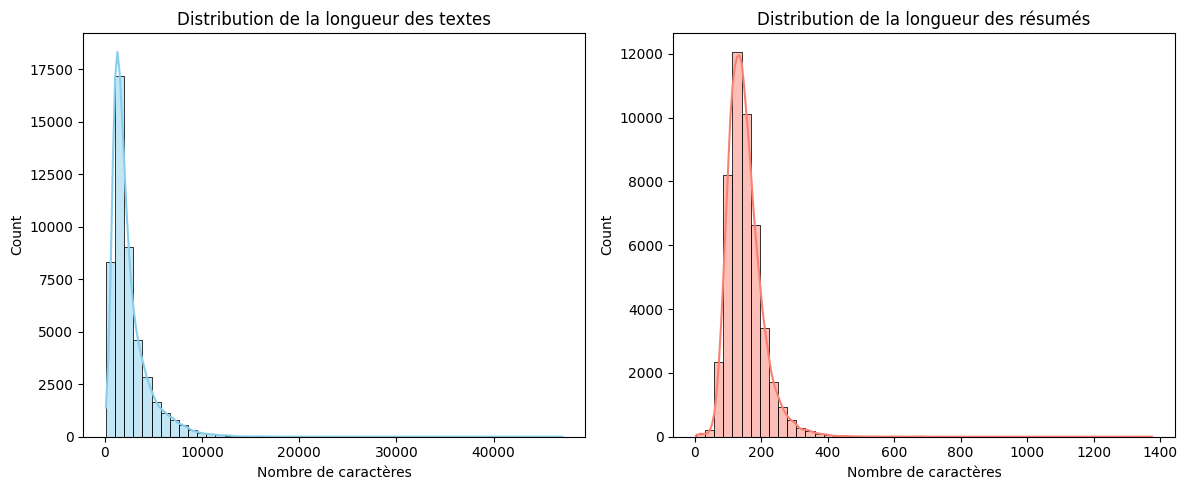

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout des longueurs
xl_sum['text_length'] = xl_sum['paragraph'].astype(str).apply(len)
xl_sum['summary_length'] = xl_sum['summary'].astype(str).apply(len)

# Histogramme
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(xl_sum['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution de la longueur des textes')
plt.xlabel('Nombre de caract√®res')

plt.subplot(1,2,2)
sns.histplot(xl_sum['summary_length'], bins=50, kde=True, color='salmon')
plt.title('Distribution de la longueur des r√©sum√©s')
plt.xlabel('Nombre de caract√®res')

plt.tight_layout()
plt.show()


In [9]:
!pip install arabic-reshaper python-bidi


In [10]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# Joindre tout le texte
all_text = ' '.join(xl_sum['paragraph'].astype(str))
reshaped_text = arabic_reshaper.reshape(all_text)
bidi_text = get_display(reshaped_text)

# G√©n√©rer le nuage
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
                      background_color='white',
                      width=800, height=400).generate(bidi_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots du texte (paragraphes)', fontsize=16)
plt.show()


In [ ]:
column_name = 'paragraph'  
xl_sum = xl_sum.drop_duplicates(subset=column_name)
column_name = 'summary'  
xl_sum = xl_sum.drop_duplicates(subset=column_name)
xl_sum.describe()

In [ ]:
counter = 0
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?¬´¬ª‚Äú‚Äù‚Äò‚Äô]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def remove_extra_spaces(input_text):
    replace = ' +'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

def replace_letters(input_text):
    replace = {"ÿ£": "ÿß","ÿ©": "Ÿá","ÿ•": "ÿß","ÿ¢": "ÿß","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items()) 
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[^\u0621-\u064A\u0660-\u0669\u06F0-\u06F90-9]'
    out_text = re.sub(replace, " ", input_text)
    #words = nltk.word_tokenize(out_text)
    #words = [word for word in words if word.isalpha()]
    #out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" Ÿë|Ÿé|Ÿã|Ÿè|Ÿå|Ÿê|Ÿç|Ÿí|ŸÄ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)
    return out_text


def text_prepare(input_text, ar_text):
    global counter
    counter +=1

    #out_text = delete_links(input_text)
    #out_text = delete_repeated_characters(out_text)
    #out_text = delete_stopwords(input_text)
    out_text = clean_text(input_text)
    #out_text = remove_extra_spaces(out_text)
    if(counter%100==0):
        print(counter,'\n',out_text)
    return out_text

In [ ]:
xl_sum['paragraph'] = xl_sum['paragraph'].apply(text_prepare, args=(True,))
xl_sum['summary'] = xl_sum['summary'].apply(text_prepare, args=(True,))

TESTER MT5 XLSUM

In [ ]:
!pip install transformers datasets evaluate


In [ ]:
!pip install rouge-score


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.optim import AdamW
from tqdm import tqdm


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # ‚úÖ version notebook pour barre propre
import pandas as pd
import nltk
import os

nltk.download('punkt')
nltk.download('stopwords')

# ========= Donn√©es =========
# Assure-toi que xl_sum est d√©j√† charg√© comme DataFrame avec colonnes ["paragraph", "summary"]
train_df, val_df = train_test_split(xl_sum, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ========= Tokenizer =========
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = MT5Tokenizer.from_pretrained(model_name)

max_input_length = 256
max_target_length = 64

class SummarizationDataset(Dataset):
    def __init__(self, source_text, target_text, tokenizer):
        self.source_text = source_text
        self.target_text = target_text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.source_text)

    def __getitem__(self, index):
        input_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        input_encoding = self.tokenizer(
            input_text,
            max_length=max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encoding["input_ids"]
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels.squeeze()
        }

# ========= Datasets & DataLoaders =========
train_dataset = SummarizationDataset(train_df["paragraph"], train_df["summary"], tokenizer)
val_dataset = SummarizationDataset(val_df["paragraph"], val_df["summary"], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

# ========= Mod√®le =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# ========= Entra√Ænement =========
epochs = 3
output_dir = "/kaggle/working/mt5_finetuned"  # modifie selon ton environnement

os.makedirs(output_dir, exist_ok=True)

for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True, ncols=100)  # ‚úÖ barre de progression horizontale propre

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"‚úÖ Moyenne de la perte √† l'√©poque {epoch+1} : {avg_loss:.4f}")

    # ‚úÖ Sauvegarde du mod√®le apr√®s chaque epoch
    epoch_dir = os.path.join(output_dir, f"epoch_{epoch+1}")
    os.makedirs(epoch_dir, exist_ok=True)
    model.save_pretrained(epoch_dir)
    tokenizer.save_pretrained(epoch_dir)
    print(f"üíæ Mod√®le sauvegard√© dans : {epoch_dir}")


In [ ]:
model.save_pretrained("/kaggle/working/mt5_arabic_xlsum_finetuned")
tokenizer.save_pretrained("/kaggle/working/mt5_arabic_xlsum_finetuned")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_path = "/kaggle/working/mt5_arabic_xlsum_finetuned"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model.to(device)
model.eval()


In [ ]:
import json

test_texts = []
test_summaries = []

with open('/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        test_texts.append(data['text'])
        test_summaries.append(data['summary'])


In [ ]:
def generate_summary(text, max_length=150, num_beams=4):
    inputs = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    summary_ids = model.generate(inputs, max_length=max_length, num_beams=num_beams, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
pred_summaries = []
for txt in test_texts:
    pred = generate_summary(txt)
    pred_summaries.append(pred)


In [ ]:
from rouge_score import rouge_scorer
import bert_score

# ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_list, rouge2_list, rougeL_list = [], [], []

for ref, pred in zip(test_summaries, pred_summaries):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougeL_list.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1 F1: {sum(rouge1_list)/len(rouge1_list):.4f}")
print(f"ROUGE-2 F1: {sum(rouge2_list)/len(rouge2_list):.4f}")
print(f"ROUGE-L F1: {sum(rougeL_list)/len(rougeL_list):.4f}")

# BERTScore
P, R, F1 = bert_score.score(pred_summaries, test_summaries, lang='ar', rescale_with_baseline=True)
print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall: {R.mean().item():.4f}")
print(f"BERTScore F1: {F1.mean().item():.4f}")


In [ ]:
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer


In [ ]:
for i in range(3):
    print("Input:", xl_sum['paragraph'].iloc[i])
    print("Target:", xl_sum['summary'].iloc[i])


In [ ]:
class ArabicSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_len=512, target_max_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_max_len = source_max_len
        self.target_max_len = target_max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        paragraph = str(self.data.loc[index, 'paragraph'])
        summary = str(self.data.loc[index, 'summary'])

        source = self.tokenizer.batch_encode_plus(
            [paragraph],
            max_length=self.source_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target = self.tokenizer.batch_encode_plus(
            [summary],
            max_length=self.target_max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [ ]:
class MT5Summarizer(pl.LightningModule):
    def __init__(self, model_name="google/mt5-small", lr=3e-5):
        super().__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = MT5Tokenizer.from_pretrained(model_name)
        self.lr = lr
        self.rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def training_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.forward(batch['input_ids'], batch['attention_mask'], batch['labels'])
        loss = output.loss

        preds = self.model.generate(batch['input_ids'], attention_mask=batch['attention_mask'], max_length=128)
        pred_str = self.tokenizer.batch_decode(preds, skip_special_tokens=True)
        label_str = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        rouge1, rouge2, rougel = 0, 0, 0
        for p, l in zip(pred_str, label_str):
            scores = self.rouge.score(p, l)
            rouge1 += scores["rouge1"].fmeasure
            rouge2 += scores["rouge2"].fmeasure
            rougel += scores["rougeL"].fmeasure

        n = len(pred_str)
        self.log('val_loss', loss, prog_bar=True)
        self.log('rouge1', rouge1 / n, prog_bar=True)
        self.log('rouge2', rouge2 / n, prog_bar=True)
        self.log('rougeL', rougel / n, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


In [ ]:
from transformers import MT5Tokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Charger le tokenizer mT5
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")

# Split train / validation
train_df, val_df = train_test_split(xl_sum, test_size=0.1, random_state=42)

# Tr√®s important : r√©initialiser l'index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Cr√©ation des datasets (tu dois avoir d√©j√† d√©fini la classe ArabicSummaryDataset)
train_dataset = ArabicSummaryDataset(train_df, tokenizer)
val_dataset = ArabicSummaryDataset(val_df, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',           # Folder where to save
    filename='mt5-best-checkpoint',    # Final file name
    save_top_k=1,                      # ‚úÖ Only one best checkpoint
    mode='min'                         # Choose lowest val_loss
)


early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=1.0,
)




model = MT5Summarizer()
trainer.fit(model, train_loader, val_loader)


In [ ]:
model.model.save_pretrained("mt5_arabic_summary_model")
tokenizer.save_pretrained("mt5_arabic_summary_model")


In [ ]:
import pandas as pd

test_df = pd.read_json("/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl", lines=True)
test_df.head()


In [ ]:
import json
import pandas as pd
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch

# Charger mod√®le et tokenizer
model = MT5ForConditionalGeneration.from_pretrained("mt5_arabic_summary_model").to("cuda")
tokenizer = MT5Tokenizer.from_pretrained("mt5_arabic_summary_model")
model.eval()


In [ ]:
# Charger fichier JSONL
test_file = '/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl'
data = []

with open(test_file, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Charger dans un DataFrame
df = pd.DataFrame(data)

# Garder 60% al√©atoirement
df_sample = df.sample(frac=0.6, random_state=42).reset_index(drop=True)


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

total_rouge1 = 0
total_rouge2 = 0
total_rougeL = 0

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    input_text = row['text']
    reference = row['summary']

    # Encode input
    inputs = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True).to("cuda")

    # Generate summary
    output = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)

    # Calculate ROUGE
    scores = scorer.score(reference, prediction)
    total_rouge1 += scores['rouge1'].fmeasure
    total_rouge2 += scores['rouge2'].fmeasure
    total_rougeL += scores['rougeL'].fmeasure

# Moyenne
n = len(df_sample)
print(f"‚úîÔ∏è R√©sultats sur 60% des donn√©es de test ({n} exemples) :")
print(f"ROUGE-1: {total_rouge1 / n:.4f}")
print(f"ROUGE-2: {total_rouge2 / n:.4f}")
print(f"ROUGE-L: {total_rougeL / n:.4f}")


In [ ]:
import json
import pandas as pd
import torch
from tqdm import tqdm
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from rouge_score import rouge_scorer

# =======================
# üì¶ Chargement du mod√®le
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "mt5_arabic_summary_model"

model = MT5ForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = MT5Tokenizer.from_pretrained(model_path)
model.eval()

print("‚úÖ Mod√®le et tokenizer charg√©s")

# =======================
# üìÑ Chargement des donn√©es
# =======================
test_path = "/kaggle/input/arabic-summarization-bbc-news/arabic_test.jsonl"

with open(test_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# ‚úÇÔ∏è Garder un √©chantillon de 60%
df_sample = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
print(f"üìä Nombre d'exemples s√©lectionn√©s : {len(df_sample)}")

# =======================
# üß† √âvaluation ROUGE
# =======================
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)  # üîÅ Pas de stemmer pour l'arabe

total_rouge1, total_rouge2, total_rougeL = 0.0, 0.0, 0.0
results = []

print("üöÄ D√©but de l'√©valuation...")
for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    input_text = row['text']
    reference = row['summary']

    # Tokenisation + g√©n√©ration
    inputs = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            inputs,
            max_length=128,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # ROUGE score
    scores = scorer.score(reference, prediction)
    total_rouge1 += scores['rouge1'].fmeasure
    total_rouge2 += scores['rouge2'].fmeasure
    total_rougeL += scores['rougeL'].fmeasure

    # Stocker les r√©sultats pour inspection manuelle
    results.append({
        "Text": input_text,
        "Reference": reference,
        "Prediction": prediction,
        "ROUGE-1": round(scores['rouge1'].fmeasure, 4),
        "ROUGE-2": round(scores['rouge2'].fmeasure, 4),
        "ROUGE-L": round(scores['rougeL'].fmeasure, 4),
    })

# =======================
# ‚úÖ R√©sultats finaux
# =======================
n = len(df_sample)
avg_r1 = total_rouge1 / n
avg_r2 = total_rouge2 / n
avg_rL = total_rougeL / n

print(f"\n‚úîÔ∏è √âvaluation sur {n} exemples :")
print(f"ROUGE-1: {avg_r1:.4f}")
print(f"ROUGE-2: {avg_r2:.4f}")
print(f"ROUGE-L: {avg_rL:.4f}")

# =======================
# üíæ Sauvegarde facultative
# =======================
results_df = pd.DataFrame(results)
results_df.to_csv("evaluation_results.csv", index=False)
print("üíæ R√©sultats d√©taill√©s sauvegard√©s dans 'evaluation_results.csv'")


In [ ]:
# Afficher quelques exemples
for i in range(5):
    print("Texte:", df_sample['text'][i][:300], '...')
    print("R√©sum√© attendu:", df_sample['summary'][i])
    
    inputs = tokenizer.encode(df_sample['text'][i], return_tensors='pt', truncation=True, max_length=512).to("cuda")
    output = model.generate(inputs, max_length=128, num_beams=4)
    generated = tokenizer.decode(output[0], skip_special_tokens=True)
    
    print("R√©sum√© g√©n√©r√©:", generated)
    print("-" * 80)


OOF SH**

In [ ]:
!pip install -q rouge-score


!pip install -q transformers datasets rouge-score sentence-transformers
MT5 ANOTHER TRY 

In [ ]:
!pip install -q transformers datasets rouge-score sentence-transformers


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import (
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
import torch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


In [ ]:
# Tu as d√©j√† nettoy√© les donn√©es
xl_sum = xl_sum.sample(frac=0.5, random_state=42).reset_index(drop=True)


In [ ]:
model_name = "google/mt5-base"  # Ou "google/mt5-large"
tokenizer = MT5Tokenizer.from_pretrained(model_name)


In [ ]:
def preprocess_function(examples):
    inputs = ["ÿ™ŸÑÿÆŸäÿµ: " + ex for ex in examples["paragraph"]]  # Ajoute le prefix "summarize:"
    targets = examples["summary"]
    
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
dataset = Dataset.from_pandas(xl_sum[['paragraph', 'summary']])
dataset = dataset.map(preprocess_function, batched=True)


In [ ]:
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test['train']
eval_dataset = train_test['test']


In [ ]:
model = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    logging_strategy="steps",
    logging_steps=200,
    save_strategy="no",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_first_step=True,
    report_to="none",
)


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
trainer.train()
